In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import re 
from operator import itemgetter
import warnings
from scipy.integrate import solve_ivp
from scipy import optimize
import seaborn as sns
from shelllock import PyCCELL_PRFQT as px
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')

# Model

![../images/master_eq_model.png](../images/master_eq_model.png)

In [2]:
sns.set_palette('colorblind')

In [3]:
def system(t,z,param):
    
    GC,GCT,Pa,Pi,Tc,Tu= z
    
    k1,k3,k4 = param  
    
    dGCdt = -(k1*GC*Tu) + k4 * GCT
    
    dGCTdt = - dGCdt
    
    dPadt = k3*GCT*Pi

    dPidt = -dPadt
    
    dTcdt = k4*GCT
    
    dTudt = -(k1*GC*Tu)
    
    return [dGCdt, dGCTdt, dPadt, dPidt, dTcdt, dTudt]

def error(param,obs):
    
    times = np.linspace(0,480,97) # number of time points
    
    t = np.linspace(0,500,500) # number of time point to solve 
    
    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([param]),
                    t_eval=times,method='DOP853',dense_output=True,rtol=1e-8,atol=1e-8)
    
    m = sol.sol(times)
    
    err = []
        
    for i in range(len(m.tolist()[2])): #don't forget that the [2] is because we are fitting the dPadt 
        if m.tolist()[2][i] < 1000:
            err.append((obs[i]-m.tolist()[2][i])**2)  
    
    erro = np.sum(err)

    return erro

In [5]:
# Import target data set

targ = pd.read_csv('../results/SHERLOCK/all_targets/pos_targets.csv')
targ.head()

,Unnamed: 0,PositiveC,100nM_Trigopus,SD,Synthetic DNA,10nM_Trigopus,IL17,40s,100µM_ToxR,EF1a,...,DnaJ09,DnaJ10_f,flaA,ToxR_f,100nM_ToxR,ToxRm1,10nM_ToxR,ToxRm2,100nM_DnaJ07,10nM_DnaJ07
0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.090476,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,3,0.0,0.0,1.211587,0.000000,0.0,0.0,0.0,0.000000,0.526190,...,0.000000,0.0,0.0,0.660476,0.000000,0.506190,0.0,0.0,0.0,0.0
4,4,0.0,0.0,1.891746,0.507302,0.0,0.0,0.0,0.376825,1.000635,...,0.193651,0.0,0.0,1.126190,0.407937,1.189048,0.0,0.0,0.0,0.0


In [30]:
#Initial conditions (concentrations in microM)
GC0 = 0.4 
GCT0 = 0.
Pa0 = 0.
Pi0 = 4.5
Tc0 = 0.
Tu0 = 1

# Parameters (in /min)
k1 = 1
k3 = 0.15
k4 = 0.01

col = 'SD' 

z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
param  = [k1,k3,k4]
bnds = [(0.00000001,1000000000),(0.00000001,1000000),(0,3)]
res = optimize.minimize(error, param, args=(list(targ[col]))
                        ,method='Nelder-Mead',bounds=bnds)#

param = [x for x in res.x]
param

[0.5283101223208991, 0.05162559536448488, 0.029342991354919027]

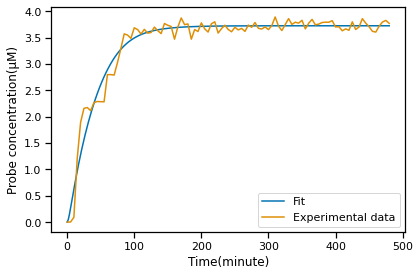

In [31]:
times = np.linspace(0,480,97*3-1)
times_exp = np.linspace(0,480,97)

sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                	t_eval=times,dense_output=True)
m = sol.sol(times)

## 
counter = 0
cleaned_m = []
for val in m[2]:
    if counter%3 == 0:
        cleaned_m.append(val)
    counter +=1
    
#r = r2_score(correct[correct.columns[1]],m[2])
r = r2_score(targ[col],cleaned_m)


sns.set_context('notebook')
#sns.set_palette("tab10")

plt.plot(times,m[2],label="Fit")
plt.errorbar(times_exp,targ[col],label="Experimental data")#,yerr=correct['0.1nM_target_std'])
plt.xlabel('Time(minute)')
plt.ylabel('Probe concentration(µM)')
#plt.title(f'R²: {(round(r*100))}, parameters: 1/k1={round(1/res.x[0],2)} min 1/k3={round(1/res.x[1],2)} min 1/k4={round(1/res.x[2],3)}min')
plt.tight_layout()
plt.legend()

plt.show()

In [94]:
def constante(t,k,p,df):
    if k == 1:
        f,l,label = 5,0,'Cas-target binding rate (sec-1)'
    else:
        f,l,label = 1,1,"Unspecific reaction rate (sec-1)"
    
    times = np.linspace(0,480,97)
    times_s = [x*60 for x in times]
 
    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([df[t]]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)

    k = [] # list that will contain all the value of k3

    for i in range(len(m[f])): 
        k.append(df.iloc[l].values[p]*m[f][i])

    k_s = [x*60 for x in k ]
    
    name = str(t).strip("_f")
    
    if t == 'flaA':
        name = t 
        
    plt.plot(times_s,k_s,label=name)
    plt.xlabel("Time (sec)")
    plt.ylabel(label)
    return k_s

In [120]:
x = [x for x in targ.columns if "Unnamed" not in x and "_sd" not in x and 'NC' not in x
     and '40s' not in x and 'ToxRm' not in x and 'nM' not in x and 'µM' not in x
    and 'Synthetic DNA' not in x and 'flaA' not in x]

#x.append('ToxRm1')
x

['PositiveC',
 'SD',
 'IL17',
 'EF1a',
 'DnaJ07',
 'Trigopus',
 'DnaJ09',
 'DnaJ10_f',
 'ToxR_f']

In [121]:
constants_t = pd.DataFrame()
times_exp = np.linspace(0,480,97)

z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
T = [0.1,0.01,100]
for i in x :
    print('Trying sequence ' +str(i)+'...')
    if '100nM' in i:
        z = [GC0,GCT0,Pa0,Pi0,Tc0,0.1]
        print(i)
    elif '10nM' in i:
        z = [GC0,GCT0,Pa0,Pi0,Tc0,0.01]
        print(i)
    elif '100µM' in i:
        z = [GC0,GCT0,Pa0,Pi0,Tc0,100]
        print(i)
    else:
        z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
        
    #'''
    res = optimize.minimize(error, param , args=(list(targ[i])),method='Nelder-Mead',bounds=bnds)
    times = np.linspace(0,480,97)

    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)
    k1,k2,k3 = res.x[0],res.x[1],res.x[2]
    
    r = r2_score(targ[i],m[2])
    
    constants_t[i] = [k1,k2,k3,r]
    
    
    print(r)
    #plt.plot(times,m[2],label="Fit")
    #plt.errorbar(times_exp,targ[i],label="Experimental data")
    #plt.xlabel('Time(minute)')
    #plt.ylabel('Probe concentration(µM)')
    #plt.title(i)
    #plt.legend()
    #plt.show()
    #'''
    print('Done for ' + str(i))
    print('---------------------------------------------------------------------')

constants_t = constants_t.rename({0: 'k1', 1: 'k3',2:'k4',3:'r2'}, axis='index')

Trying sequence PositiveC...
0.9384625821992686
Done for PositiveC
---------------------------------------------------------------------
Trying sequence SD...
0.95948056032452
Done for SD
---------------------------------------------------------------------
Trying sequence IL17...
0.958410226121197
Done for IL17
---------------------------------------------------------------------
Trying sequence EF1a...
0.9622136783098377
Done for EF1a
---------------------------------------------------------------------
Trying sequence DnaJ07...
0.8608555066108612
Done for DnaJ07
---------------------------------------------------------------------
Trying sequence Trigopus...
0.962340317345375
Done for Trigopus
---------------------------------------------------------------------
Trying sequence DnaJ09...
0.9510787233994341
Done for DnaJ09
---------------------------------------------------------------------
Trying sequence DnaJ10_f...
0.9390111625206429
Done for DnaJ10_f
----------------------------

constants_t.to_csv('../images/SHERLOCK/modeling/constants.csv')

In [61]:
constants_t = pd.read_csv('../images/SHERLOCK/modeling/constants.csv')
constants_t

,PositiveC,100nM_Trigopus,SD,Synthetic DNA,10nM_Trigopus,IL17,100µM_ToxR,EF1a,DnaJ07,Trigopus,DnaJ09,DnaJ10_f,flaA,ToxR_f,100nM_ToxR,10nM_ToxR,100nM_DnaJ07,10nM_DnaJ07
k1,0.050505,0.055664,0.528310,0.017983,0.212536,0.030406,0.603364,0.167474,0.093541,0.023731,0.105278,0.013070,0.765227,0.331189,0.050737,0.044159,0.039307,0.000228
k3,0.034603,0.340192,0.051626,0.106235,0.211070,0.081899,0.014367,0.042680,0.033919,0.083917,0.041852,0.004239,0.003431,0.029603,0.218639,0.045825,0.083313,2.330513
k4,0.025449,0.021239,0.029343,0.000000,0.000000,0.023100,0.042048,0.023696,0.027792,0.019977,0.027688,0.016817,0.005918,0.024709,0.013964,0.000061,0.000000,0.000000
r2,0.938463,0.968087,0.959481,0.957348,0.939118,0.958410,0.539359,0.962214,0.860856,0.962340,0.951079,0.939011,0.962721,0.963719,0.980606,0.928741,0.881285,0.918620


In [122]:
c = constants_t.copy()

In [123]:
c= c.loc[:,constants_t.loc['r2'] > 0.85]
c.drop(index='r2', axis=1, inplace=True) 

c

,PositiveC,SD,IL17,EF1a,DnaJ07,Trigopus,DnaJ09,DnaJ10_f,ToxR_f
k1,0.050505,0.528310,0.030406,0.167474,0.093541,0.023731,0.105278,0.013070,0.331189
k3,0.034603,0.051626,0.081899,0.042680,0.033919,0.083917,0.041852,0.004239,0.029603
k4,0.025449,0.029343,0.023100,0.023696,0.027792,0.019977,0.027688,0.016817,0.024709


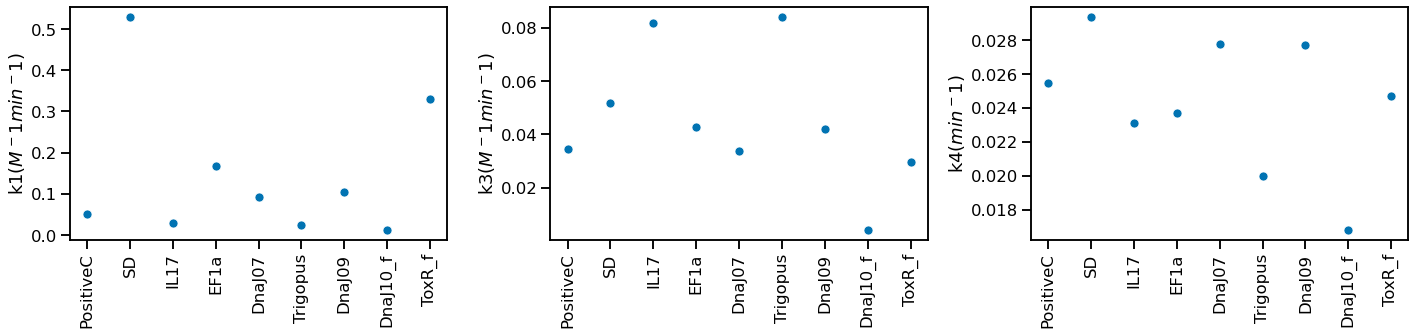

In [124]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)

counter = 0

for i in c.index:
    #if i == c.index[-1]:
        #break
    n = [x for x in c.loc[i].index]

    sns.scatterplot([x for x in range(len(c.loc[i]))],c.loc[i],ax =ax[counter])
    
    ax[counter].set_xticks([x for x in range(len(c.loc[i]))])

    ax[counter].set_xticklabels(n,rotation=90)
    
    if i != 'k4':
        ax[counter].set_ylabel(str(i)+'($M^-1min^-1$)')
    else:
        ax[counter].set_ylabel(str(i)+'($min^-1$)')
    counter+=1

plt.tight_layout()
#plt.savefig('../images/SHERLOCK/modeling/distribution_constants.png',dpi=300)
plt.show()

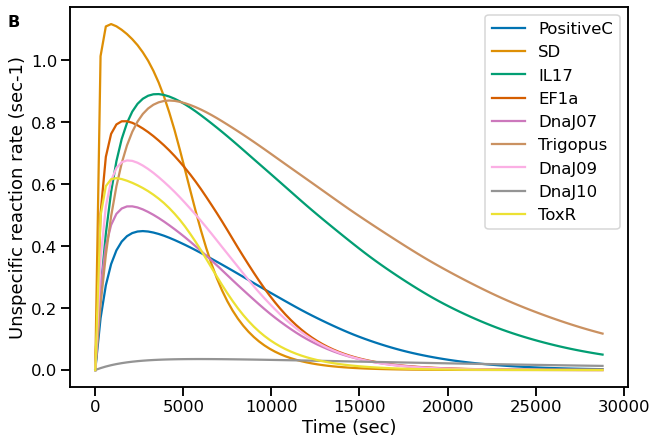

In [125]:
s=[]
plt.figure(figsize=(10,7))
sns.set_context('talk')
counter = 0 
for i in c.columns:
    s.append(constante(i,3,counter,c))
    counter += 1
    
plt.legend()
plt.text(-5000,1.11,'B',
        fontsize=16, fontweight='bold')
plt.savefig('../images/SHERLOCK/modeling/reaction_rates_targets.png',dpi=300)
plt.show()

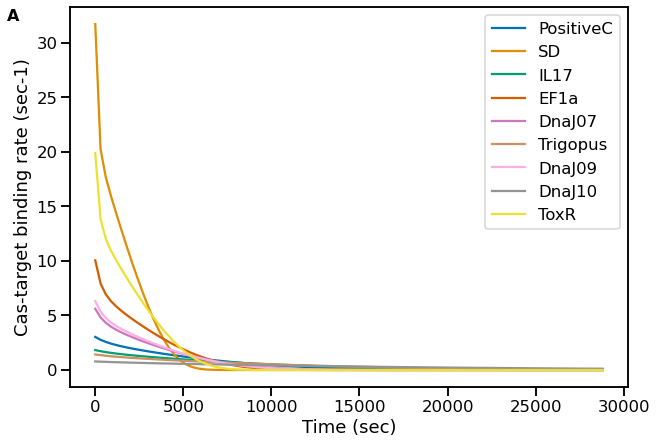

In [127]:
plt.figure(figsize=(10,7))
sns.set_context('talk')
counter = 0 
for i in c.columns:
    constante(i,1,counter,c)
    counter += 1
    
plt.legend()
plt.text(-5000,32,'A',
        fontsize=16, fontweight='bold')
plt.savefig('../images/SHERLOCK/modeling/binding_rates_targets.png',dpi=300)
plt.show()